In [1]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers

In [2]:
import os
    # operating system module
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    for folder2_name in ("test", "train", "val"):
        folder_path = os.path.join("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/chest_xray", folder2_name, folder_name)
        for fname in os.listdir(folder_path):
            # Getting all filenames and directory names in folder_path
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                # open file in binary format
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                # converts the string "JFIF" to bytes and .peek(10) gets the first 10 bytes
            finally:
                fobj.close()
            
            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)
                # delete image since it doesn't contain JFIF string (not png image)
            
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/chest_xray/train",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=1337,
                                                               image_size=image_size,
                                                               batch_size=batch_size )
val_ds = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/chest_xray/val",
                                                             validation_split=0.2,
                                                             subset="validation",
                                                             seed=1337,
                                                             image_size=image_size,
                                                             batch_size=batch_size )

Found 5043 files belonging to 2 classes.
Using 4035 files for training.
Found 10 files belonging to 2 classes.
Using 2 files for validation.


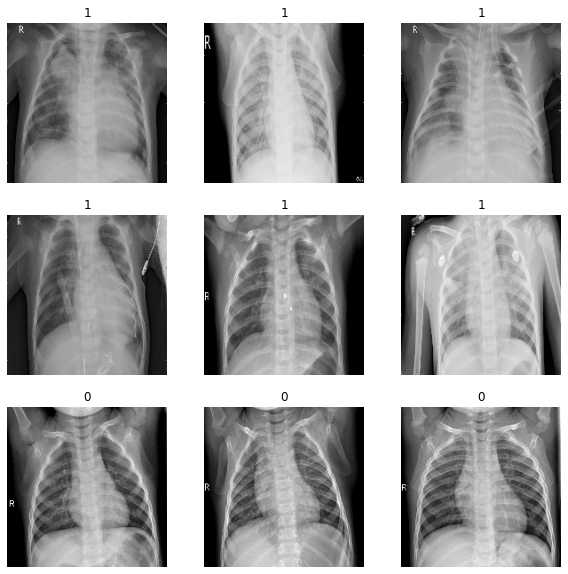

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
# Do minor changes to images to help model reduce overfitting (rotate and flip images)
data_augmentation = ks.Sequential( [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1)] )

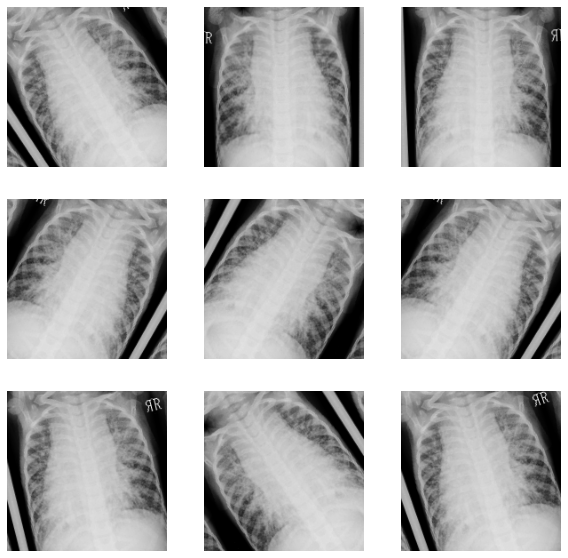

In [6]:
# Changes that data_augmentation does on an image
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
# Since we are training on CPU, we will perform data augmentation to the dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
augmented_train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
def make_model(input_shape, num_classes):
    inputs = ks.Input(shape=input_shape)
    
    x = inputs
    
    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return ks.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
ks.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [14]:
# the number of times the learning model will work throughout the training data
epochs = 10

callbacks = [ks.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model.compile(optimizer = ks.optimizers.Adam(1e-3), loss = "binary_crossentropy",
              metrics=["accuracy"])
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)
#model.fit(augmented_train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/10
127/127 [==============================] - 453s 4s/step - loss: 0.0288 - accuracy: 0.9893 - val_loss: 2.4548e-06 - val_accuracy: 1.0000
Epoch 2/10
127/127 [==============================] - 440s 3s/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 1.5428e-05 - val_accuracy: 1.0000
Epoch 3/10
127/127 [==============================] - 448s 4s/step - loss: 0.0129 - accuracy: 0.9943 - val_loss: 7.9824e-07 - val_accuracy: 1.0000
Epoch 4/10
127/127 [==============================] - 449s 4s/step - loss: 0.0097 - accuracy: 0.9968 - val_loss: 1.0514e-08 - val_accuracy: 1.0000
Epoch 5/10
127/127 [==============================] - 455s 4s/step - loss: 0.0667 - accuracy: 0.9750 - val_loss: 1.5312e-09 - val_accuracy: 1.0000
Epoch 6/10
127/127 [==============================] - 449s 4s/step - loss: 0.0495 - accuracy: 0.9822 - val_loss: 3.9059e-06 - val_accuracy: 1.0000
Epoch 7/10
127/127 [==============================] - 456s 4s/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 2.388

# Since Accuracy is ~99%, we may proceed into predictions

In [15]:
# Validating
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/chest_xray/val", folder_name)
    for fname in os.listdir(folder_path):
        fname = os.path.join(folder_path, fname)
        image = ks.preprocessing.image.load_img(fname, target_size = image_size)
        image_array = ks.preprocessing.image.img_to_array(image)
        image_array = tf.expand_dims(image_array, 0)
        
        predictions = model.predict(image_array)
        score = predictions[0]
        print("There is approximately a " + str(int(100*(1-score))) + " Percent chance that the x-ray is Normal and\n" 
              + "                      " + str(int(100*score)) + " percent chance that it detected pneumonia.")

There is approximately a 29 Percent chance that the x-ray is Normal and
                      70 percent chance that it detected pneumonia.
There is approximately a 99 Percent chance that the x-ray is Normal and
                      0 percent chance that it detected pneumonia.
There is approximately a 0 Percent chance that the x-ray is Normal and
                      99 percent chance that it detected pneumonia.
There is approximately a 0 Percent chance that the x-ray is Normal and
                      99 percent chance that it detected pneumonia.
There is approximately a 0 Percent chance that the x-ray is Normal and
                      99 percent chance that it detected pneumonia.
There is approximately a 0 Percent chance that the x-ray is Normal and
                      99 percent chance that it detected pneumonia.
There is approximately a 0 Percent chance that the x-ray is Normal and
                      99 percent chance that it detected pneumonia.
There is approximately a 0

In [16]:
# Predicting
answer = []
pred = []
pred.clear()
i = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/chest_xray/test", folder_name)
    for fname in os.listdir(folder_path):
        fname = os.path.join(folder_path, fname)
        image = ks.preprocessing.image.load_img(fname, target_size = image_size)
        image_array = ks.preprocessing.image.img_to_array(image)
        image_array = tf.expand_dims(image_array, 0)
        
        predictions = model.predict(image_array)
        score = predictions[0]
        if score > (1-score):
            pred.append("Pneumonia")
            i += 1
        if score < (1-score):
            pred.append("Normal")
            i += 1
        if score == (1-score):
            pred.append("unknown")
            i += 1
for i in range(0,234):
    answer.append('Normal')

for i in range(0, 352):
    answer.append('Pneumonia')

In [17]:
data = {'Answer':answer, 'Prediction': pred}
import pandas as pd
Results = pd.DataFrame(data, columns = ['Answer', 'Prediction'])
Results

,Answer,Prediction
0,Normal,Normal
1,Normal,Pneumonia
2,Normal,Normal
3,Normal,Pneumonia
4,Normal,Normal
...,...,...
581,Pneumonia,Pneumonia
582,Pneumonia,Pneumonia
583,Pneumonia,Pneumonia
584,Pneumonia,Pneumonia


In [18]:
Results.to_csv("Results_nonaugmented.csv")

In [19]:
aug_results = pd.read_csv("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/Results.csv")
nonaug_results = pd.read_csv("C:/Users/falka/OneDrive - Old Dominion University/Personal_Project/Results_nonaugmented.csv")
print(aug_results)
print(nonaug_results)

     Unnamed: 0     Answer Prediction
0             0     Normal  Pneumonia
1             1     Normal  Pneumonia
2             2     Normal  Pneumonia
3             3     Normal  Pneumonia
4             4     Normal  Pneumonia
..          ...        ...        ...
581         581  Pneumonia  Pneumonia
582         582  Pneumonia  Pneumonia
583         583  Pneumonia  Pneumonia
584         584  Pneumonia  Pneumonia
585         585  Pneumonia  Pneumonia

[586 rows x 3 columns]
     Unnamed: 0     Answer Prediction
0             0     Normal     Normal
1             1     Normal  Pneumonia
2             2     Normal     Normal
3             3     Normal  Pneumonia
4             4     Normal     Normal
..          ...        ...        ...
581         581  Pneumonia  Pneumonia
582         582  Pneumonia  Pneumonia
583         583  Pneumonia  Pneumonia
584         584  Pneumonia  Pneumonia
585         585  Pneumonia  Pneumonia

[586 rows x 3 columns]


In [20]:
aug_results = aug_results.iloc[:,1:]
nonaug_results = nonaug_results.iloc[:,1:]

In [21]:
import numpy as np
aug_results['Correct'] = np.where(aug_results['Answer'] == aug_results['Prediction'], 'YES', 'NO')
nonaug_results['Correct'] = np.where(nonaug_results['Answer'] == nonaug_results['Prediction'], 'YES', 'NO')
print(aug_results)
print(nonaug_results)

        Answer Prediction Correct
0       Normal  Pneumonia      NO
1       Normal  Pneumonia      NO
2       Normal  Pneumonia      NO
3       Normal  Pneumonia      NO
4       Normal  Pneumonia      NO
..         ...        ...     ...
581  Pneumonia  Pneumonia     YES
582  Pneumonia  Pneumonia     YES
583  Pneumonia  Pneumonia     YES
584  Pneumonia  Pneumonia     YES
585  Pneumonia  Pneumonia     YES

[586 rows x 3 columns]
        Answer Prediction Correct
0       Normal     Normal     YES
1       Normal  Pneumonia      NO
2       Normal     Normal     YES
3       Normal  Pneumonia      NO
4       Normal     Normal     YES
..         ...        ...     ...
581  Pneumonia  Pneumonia     YES
582  Pneumonia  Pneumonia     YES
583  Pneumonia  Pneumonia     YES
584  Pneumonia  Pneumonia     YES
585  Pneumonia  Pneumonia     YES

[586 rows x 3 columns]


In [28]:
print("Number of Correct Predicitions in model trained by augmented data:\n" 
      "                          "+ str(len(aug_results[aug_results['Correct'] == 'YES'].index)) + " out of 586 images")
print("\nNumber of Correct Predicitions in model trained by augmented data:\n" 
      "                          "+ str(len(nonaug_results[nonaug_results['Correct'] == 'YES'].index)) + " out of 586 images")

Number of Correct Predicitions in model trained by augmented data:
                          366 out of 586 images

Number of Correct Predicitions in model trained by augmented data:
                          441 out of 586 images
